In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io
from skimage import filters, morphology

In [2]:
from seghub.classif_utils import get_kmeans_clusters, get_pca_features, features_combinator
from seghub.vgg16_utils import get_vgg16_features_targets, get_vgg16_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_segforest, predict_segforest_single_image, predict_segforest, selfpredict_segforest_single_image, segment_segforest

c:\Users\roman\anaconda3\envs\seghub_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
shark_vid = skvideo_io.vread("../data/shark_test_vid.AVI")
print(shark_vid.shape)

(744, 480, 640, 3)


In [4]:
img = shark_vid[0] / 255
# img = img[:,:,0]
print("SHAPE:", img.shape, "\nTYPE:", img.dtype, "\nRANGE:", img.min(), "-", img.max())

SHAPE: (480, 640, 3) 
TYPE: float64 
RANGE: 0.0 - 1.0


In [8]:
v = napari.view_image(img)

In [5]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")
print(labels.shape)
print(np.sum(labels > 0))

(480, 640)
2480


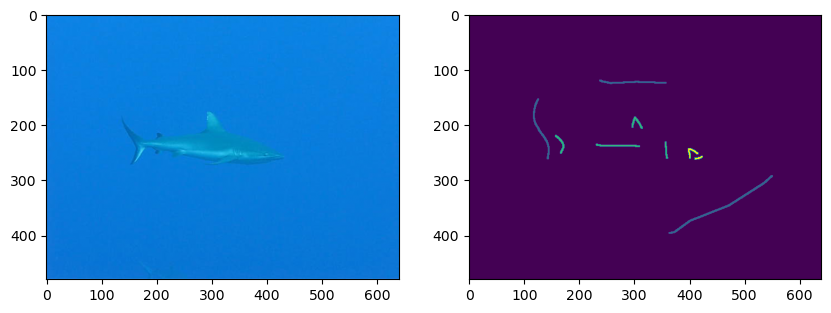

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(labels)

## VGG16 (Convpaint)

In [9]:
feature_space = get_vgg16_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(feature_space.shape)

(480, 640, 128)


In [10]:
# Because of edge problems in the current version of convpaint, we exclude the edge features
overall_means = np.mean(np.mean(feature_space, axis=0),axis=0)
feature_space[:5] = overall_means
feature_space[-5:] = overall_means
feature_space[:,:5] = overall_means
feature_space[:,-5:] = overall_means

In [11]:
# Show how the smoothened feature space looks like
# feature_space = np.moveaxis(feature_space, 2, 0)
# feature_space = np.array([filters.median(f, footprint=morphology.disk(5)) for f in feature_space])
# feature_space = np.moveaxis(feature_space, 0, 2)

In [12]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space VGG16")

<Image layer 'Feature Space VGG16' at 0x24d3b7ead00>

In [13]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


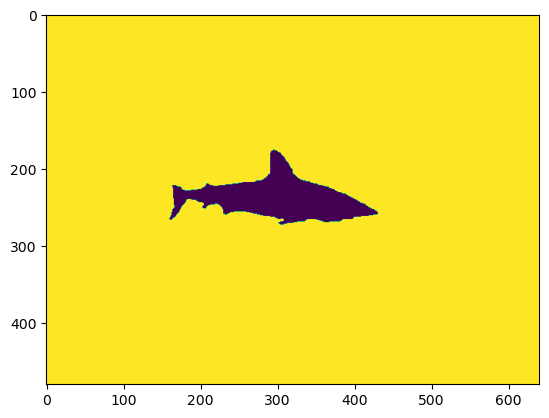

In [14]:
plt.imshow(kmeans_f)

In [15]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


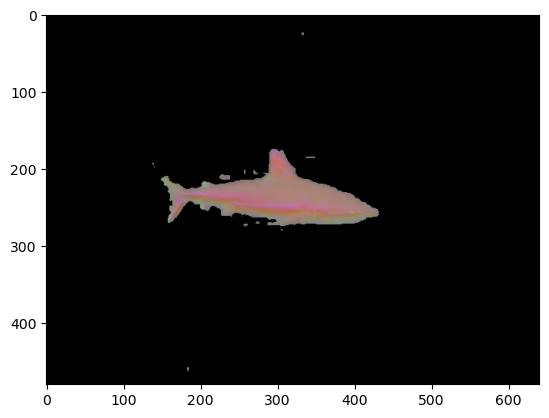

In [16]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

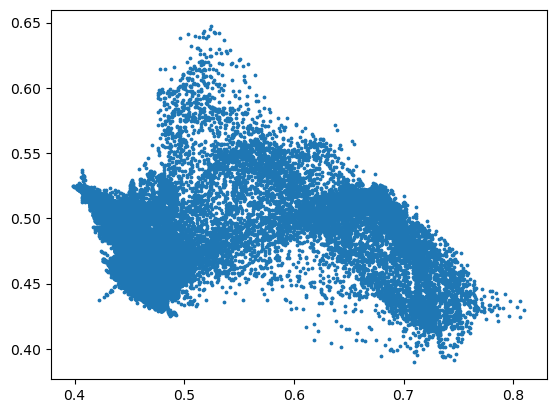

In [17]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [18]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


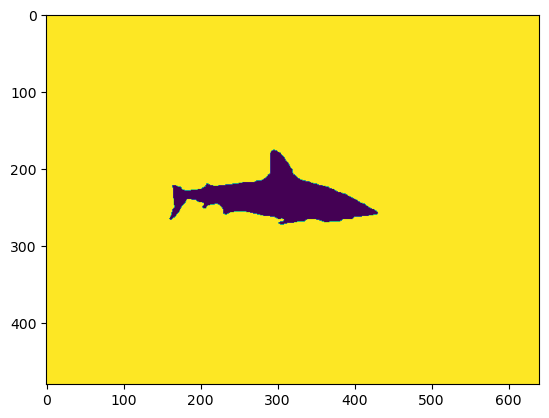

In [19]:
plt.imshow(kmeans_p)

In [20]:
annot_features, targets = get_vgg16_features_targets(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

(2480, 128)
(2480,)


In [21]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


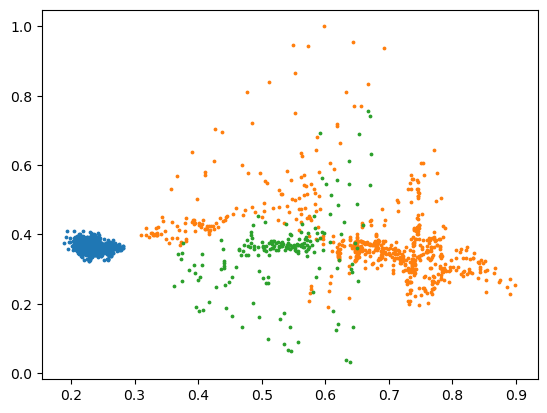

In [22]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [23]:
used_model = "s_r"
# used_model = "uni"

In [24]:
# # For use of the UNI model, we need to login to the Hugging Face Hub with access to the model
# hf_token = input("paste your huggingface token here: ")
# from huggingface_hub import login; login(hf_token)

In [25]:
patch_features = get_dinov2_patch_features(img, dinov2_model=used_model)
print(patch_features.shape)

C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


(1610, 384)


In [26]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False, dinov2_model=used_model)
print(pix_features.shape)

(307200, 384)


In [27]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False, dinov2_model=used_model)
print(feature_space.shape)

(480, 640, 384)


In [28]:
# Show how the smoothened feature space looks like
# feature_space = np.moveaxis(feature_space, 2, 0)
# feature_space = np.array([filters.median(f, footprint=morphology.disk(5)) for f in feature_space])
# feature_space = np.moveaxis(feature_space, 0, 2)

In [29]:
v.add_image(np.moveaxis(feature_space, -1, 0), name=f"Feature Space DINOv2 ({used_model})")

<Image layer 'Feature Space DINOv2 (s_r)' at 0x24d41cc5910>

In [30]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


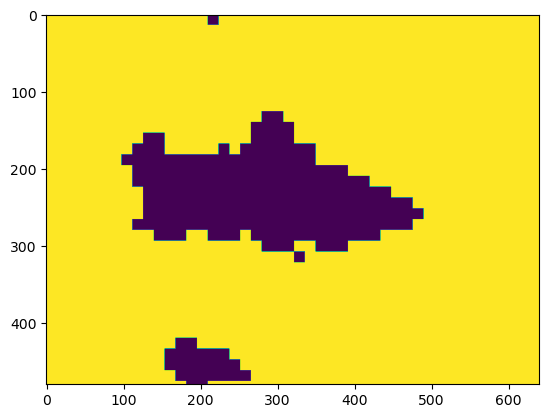

In [31]:
plt.imshow(kmeans_f)

In [32]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


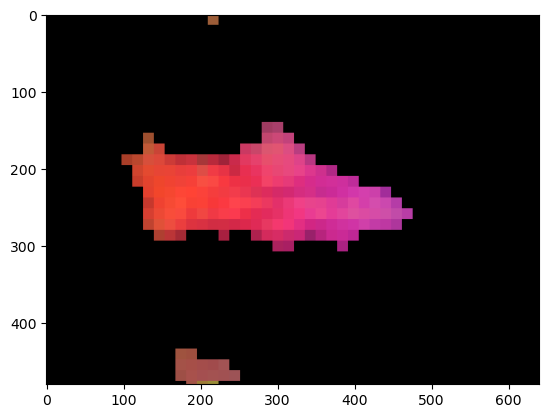

In [33]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.6
three_pc[pc_mask] = 0
plt.imshow(three_pc)

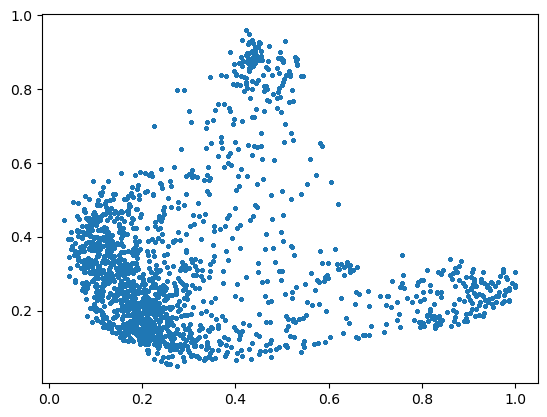

In [34]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [35]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


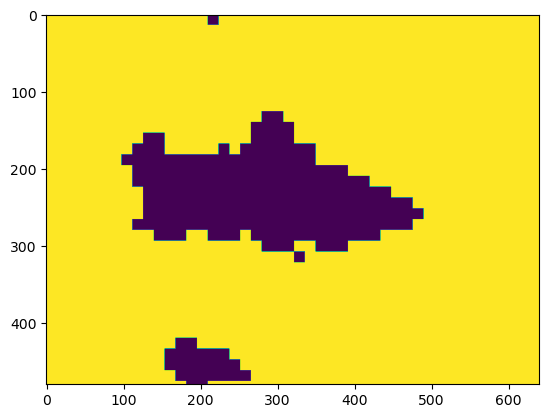

In [36]:
plt.imshow(kmeans_p)

In [37]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [38]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


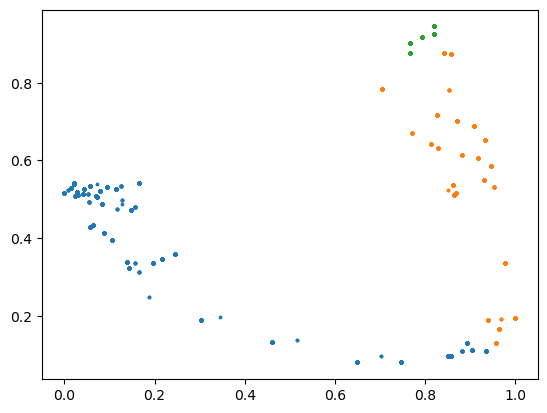

In [39]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [40]:
feature_space = get_ila_feature_space(img)
print(feature_space.shape)

(480, 640, 168)


In [41]:
# Show how the smoothened feature space looks like
# feature_space = np.moveaxis(feature_space, 2, 0)
# feature_space = np.array([filters.median(f, footprint=morphology.disk(5)) for f in feature_space])
# feature_space = np.moveaxis(feature_space, 0, 2)

In [42]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x24d368d04f0>

In [43]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


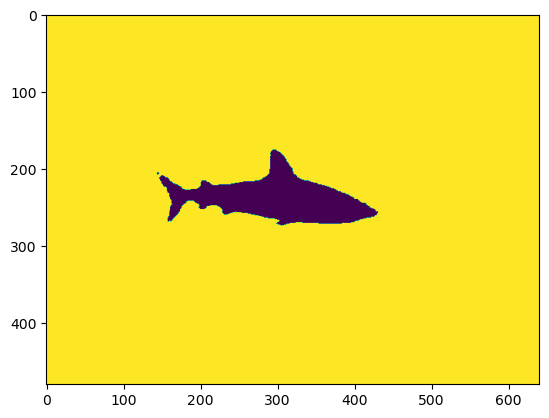

In [44]:
plt.imshow(kmeans_f)

In [45]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


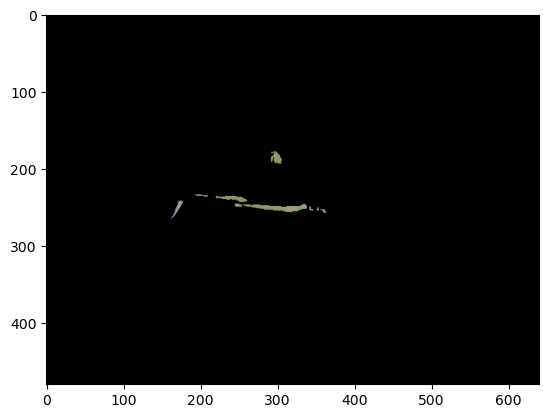

In [46]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

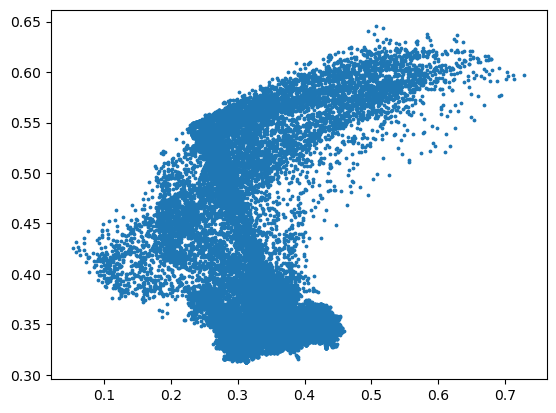

In [47]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [48]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


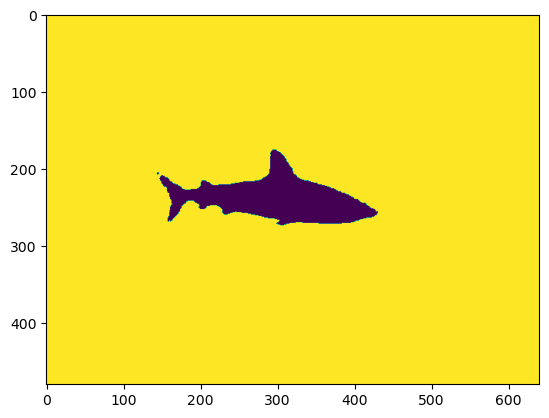

In [49]:
plt.imshow(kmeans_p)

In [50]:
annot_features, targets = get_ila_features_targets(img, labels)

In [51]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


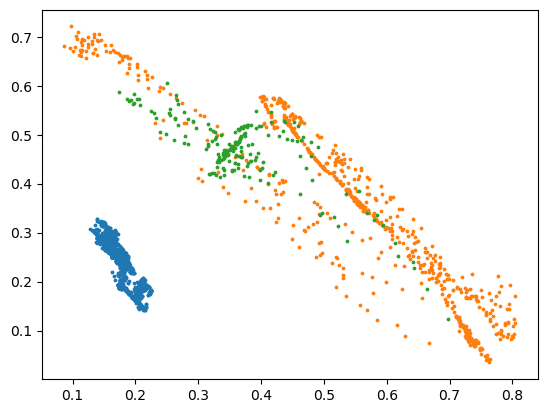

In [52]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Combine CGG16 and DINOv2

In [6]:
feature_funcs = [get_vgg16_feature_space, get_dinov2_feature_space]
feature_cfgs = [{"layer_list":[0], "scalings":[1,2], "model_name":"vgg16"},
                 {"interpolate_features":False, "dinov2_model":"s_r"}]

feature_space = features_combinator(img, feature_funcs, feature_cfgs,
                                    num_pcs_list=None, feature_smoothness_list=None, img_as_feature=False)

C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\roman/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [9]:
v.add_image(np.moveaxis(feature_space, -1, 0), name = "Combination (VGG16 & DINOv2)")

<Image layer 'Combination (VGG16 & DINOv2)' at 0x2a5c6b76820>

In [10]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


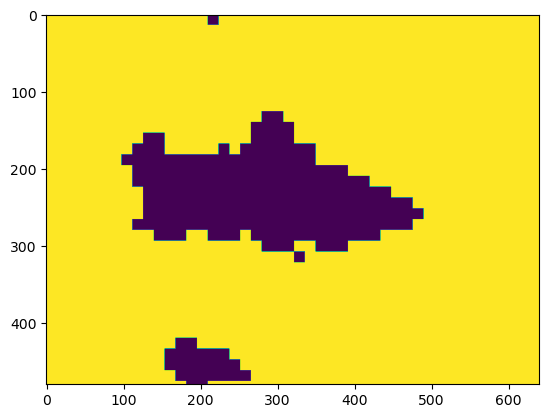

In [11]:
plt.imshow(kmeans_f)

In [12]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


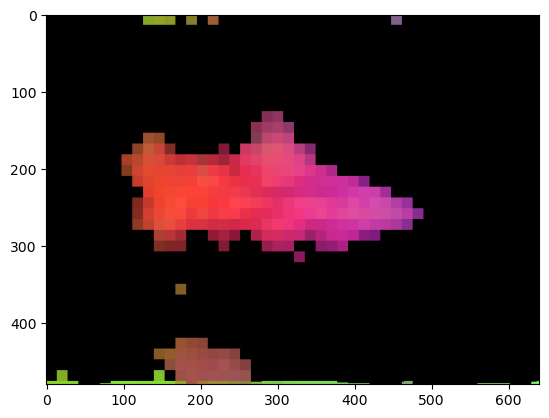

In [13]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

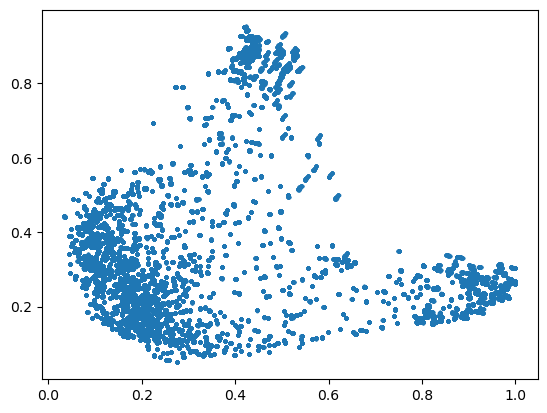

In [14]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [15]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


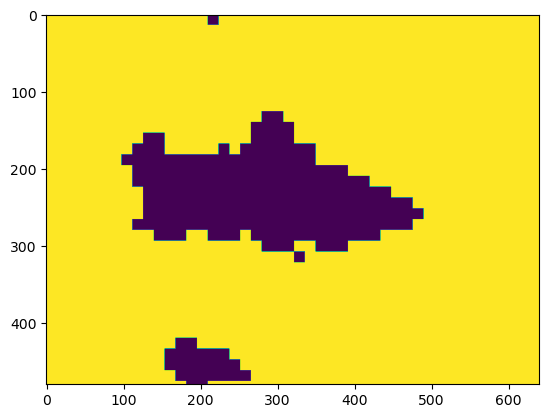

In [16]:
plt.imshow(kmeans_p)

## Test random forest functions

In [17]:
# features_func_train = get_vgg16_feature_space
# features_func_pred = get_vgg16_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_feature_space
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc_as_features": 0, "dinov2_model":"s_r"}
# features_func_train = get_ila_feature_space
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [18]:
# # For use of the UNI model, we need to login to the Hugging Face Hub with access to the model
# hf_token = input("paste your huggingface token here: ")
# from huggingface_hub import login; login(hf_token)

In [19]:
rf = train_segforest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [20]:
pred = predict_segforest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


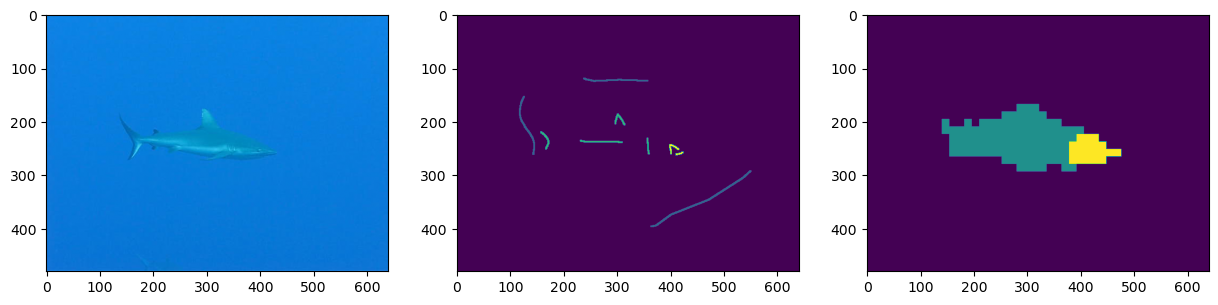

In [21]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(pred)

In [22]:
pred_vid = shark_vid.copy()/255
pred_vid = pred_vid[:40:4]

In [23]:
pred_batch = predict_segforest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/10 - estimated time left: NA
Predicting image 2/10 - estimated time left: 56.2 seconds
Predicting image 3/10 - estimated time left: 46.9 seconds
Predicting image 4/10 - estimated time left: 37.5 seconds
Predicting image 5/10 - estimated time left: 30.2 seconds
Predicting image 6/10 - estimated time left: 24.1 seconds
Predicting image 7/10 - estimated time left: 18.8 seconds
Predicting image 8/10 - estimated time left: 13.8 seconds
Predicting image 9/10 - estimated time left: 9.3 seconds
Predicting image 10/10 - estimated time left: 4.7 seconds


In [24]:
v2 = napari.view_image(pred_vid)
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x2a6057ca850>

Use selfpredict function

In [25]:
selfpred = selfpredict_segforest_single_image(img, labels, features_func_train, features_cfg, random_state=0)

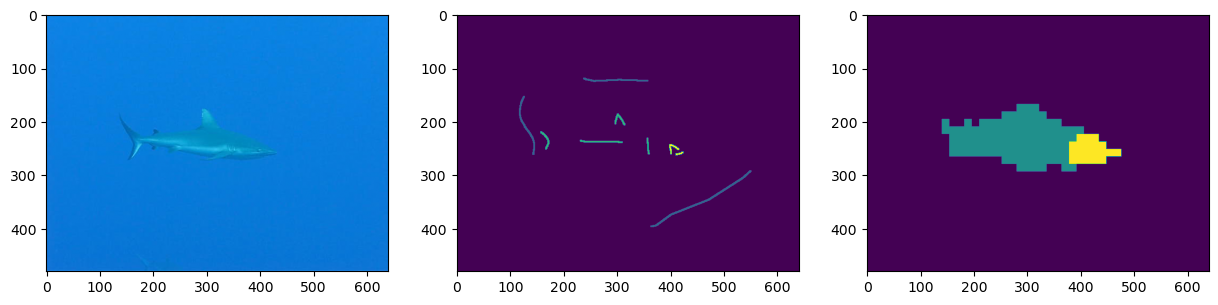

In [26]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(selfpred)

Use function to train and predict on different batches/movies

In [27]:
train_vid = [img]
train_labels = [labels]
pred_vid = shark_vid[100:105].copy()/255

In [28]:
pred_vid_seg = segment_segforest(train_vid, train_labels, pred_vid, features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA
Predicting image 1/5 - estimated time left: NA
Predicting image 2/5 - estimated time left: 21.6 seconds
Predicting image 3/5 - estimated time left: 15.6 seconds
Predicting image 4/5 - estimated time left: 10.7 seconds
Predicting image 5/5 - estimated time left: 5.3 seconds


In [29]:
v3 = napari.view_image(train_vid)
v3.add_labels(labels)
v3.add_image(pred_vid)
v3.add_labels(pred_vid_seg)

<Labels layer 'pred_vid_seg' at 0x2a5a040bc40>

Show the impact of additional options

In [30]:
selfpred = selfpredict_segforest_single_image(img, labels, features_func_train, features_cfg, random_state=0,
                                               pcs_as_features=3, feature_smoothness=0, img_as_feature=True, pred_smoothness=8)

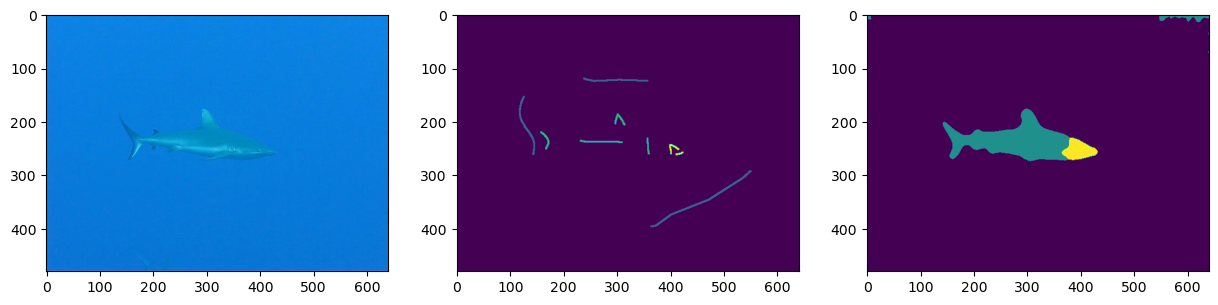

In [31]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(selfpred)

Show using combined features

In [32]:
feature_funcs = [get_vgg16_feature_space, get_ila_feature_space, get_dinov2_feature_space]
feature_cfgs = [{"layer_list":[0], "scalings":[1,2], "model_name":"vgg16"},
                {},
                {"interpolate_features":False, "dinov2_model":"s_r"}]
combinator_cfg = {"features_func_list":feature_funcs, "features_cfg_list":feature_cfgs,
                  "num_pcs_list":None, "feature_smoothness_list":None, "img_as_feature":False}

In [33]:
pred = selfpredict_segforest_single_image(img, labels, features_combinator, combinator_cfg, random_state=0,
                                           pred_smoothness=3)

In [34]:
v.add_labels(pred, name="Prediction")

<Labels layer 'Prediction' at 0x2a606988850>

### Try other functions from scipy and skimage

In [35]:
from scipy.cluster.hierarchy import dendrogram, fclusterdata, linkage
from skimage.restoration import denoise_bilateral

In [ ]:
pix_features.shape

In [ ]:
clust = fclusterdata(patch_features, criterion="distance", t=2)
print(clust.shape, clust[:10])

(1610,) [379 380 388 386 387 382 995 383 996   8]


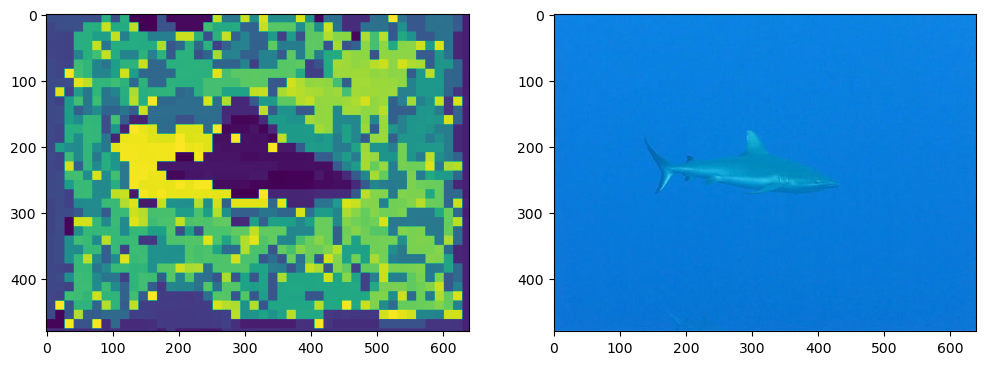

In [ ]:
from seghub.util_funcs import reshape_patches_to_img, calculate_padding
padding = calculate_padding(img.shape[:2], patch_size=(14,14))
padded_img_shape = (img.shape[0]+padding[0], img.shape[1]+padding[1])
clust_img = reshape_patches_to_img(clust, padded_img_shape, patch_size=(14,14))[:img.shape[0], :img.shape[1]]
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(clust_img)
ax[1].imshow(img)

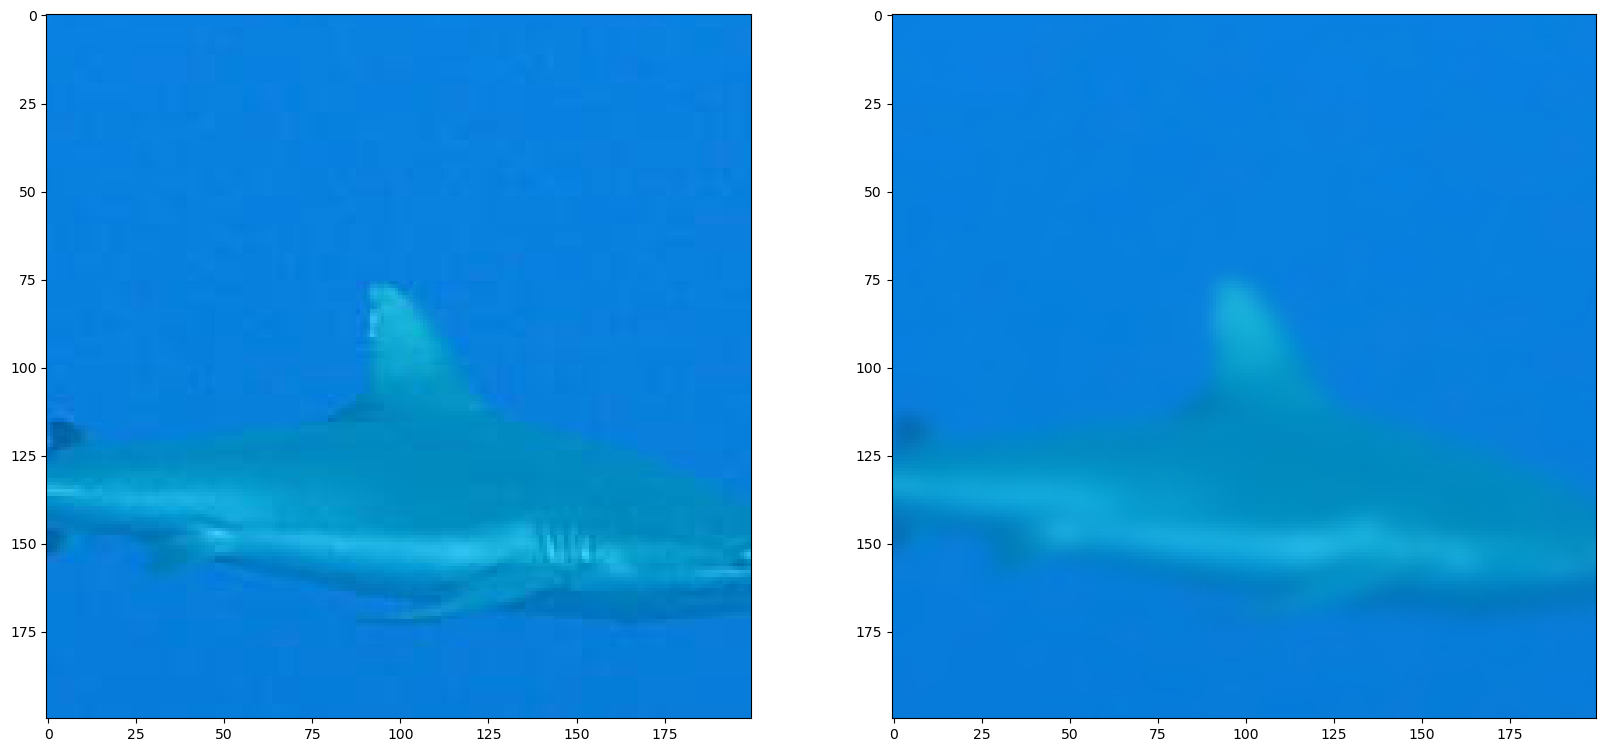

In [ ]:
denoised_img = denoise_bilateral(img, channel_axis=-1, win_size=3, sigma_color=0.1, sigma_spatial=2)
# denoised_img = denoise_bilateral(denoised_img, channel_axis=-1, win_size=3, sigma_color=0.1, sigma_spatial=2)

fig, ax = plt.subplots(1,2, figsize = (20,10))
ax[0].imshow(img[100:300,200:400])
ax[1].imshow(denoised_img[100:300,200:400])